In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns


# Økonometri A



## Problem Set 7



### Hedonic price regressions



In this problem set, we examine if there is heteroskedasticity in the hedonic price model and implement methods to correct for it. If heteroskedasticity is present, the variance of the error terms is different across observations and conventional $t$ and $F$ tests are invalid.

For the analysis, we use graphical and formal tests of heteroskedasticity and implement the method of Weighted Least Squares (WLS) that estimates the model parameters efficiently.

In problem set 6, one of the hedonic price models we worked with was:

$$
\log(\text{price}_i) = \beta_0 + \delta_1 \text{KbhK}_i + \delta_2 \text{KbhN}_i + \delta_3 \text{KbhV}_i + \beta_1 \text{m2}_i + \beta_2 \text{m2}^2_i + \beta_3 \text{rooms}_i + \beta_4 \text{toilets}_i + u_i \tag{1}
$$

We will examine a modified version of the model, where the dependent variable is price measured in DKK (without taking the log):

$$
\text{price}_i = \beta_0 + \delta_1 \text{KbhK}_i + \delta_2 \text{KbhN}_i + \delta_3 \text{KbhV}_i + \beta_1 \text{m2}_i + \beta_2 \text{m2}^2_i + \beta_3 \text{rooms}_i + \beta_4 \text{toilets}_i + u_i \tag{2}
$$

The problem of heteroskedasticity may in some cases be reduced — and even removed — by taking the log of the dependent variable. This was one motivation for estimating model (1) in the previous problem set. In problem set 7, we start by analyzing model (2) to see if it indeed suffers from heteroskedasticity.



### Group work



Discuss the following questions in groups.



#### Task 1. 

Suppose that assumption MLR.5 **does not** hold for model (2). What does this mean for the properties of the OLS estimator?


**Your answer:**

> OLS estimatoren er middelret og konsistent under MLR.1–MLR.4, men den estimerede kovarians-matrix for modellens parametre er ikke længere gyldig. Det indebærer at $t$ og $F$ tests ikke længere er $t$ og $F$ fordelt, hvorfor standard hypotesetests ikke kan bruges. Endvidere er OLS ikke længere BLUE — der findes andre lineære middelrette estimatorer med mindre varians (større efficiens).



#### Task 2. 
Suppose that apartment size, $m2_i$, affects the variance of the error term and is thus a relevant scale variable driving the heteroskedasticity. Provide an economic argument for why the variance of the error terms may depend on apartment size. Explain how it is possible for the error terms to satisfy MLR.4, but not MLR.5.


**Your answer:**

> Man forestiller sig, at større lejligheder er udsat for større usikkerhed, når prisen skal bestemmes. Fx kan efterspørgslen være mere volatil for store lejligheder, hvilket kan medføre heteroskedastiske fejlled. Det hænger tæt sammen med begrebet "tynde" markeder, som er karakteriseret ved få markedstransaktioner, der gør det svært at sige, hvad den rette ligevægtspris er. At fejlleddet opfylder MLR.4, men ikke MLR.5, betyder at fejlleddet i gennemsnit er nul, men det har forskellig varians på tværs af observationerne.


#### Task 3. 
Write down an expression for the conditional variance of $u_i$ for the case where the variance of the error term is exactly proportional to $m2_i$. How can the WLS estimator be implemented in this case?


**Your answer:**

> Hvis variansen på fejlleddet er ligefrem proportional med $m2$, så gælder der at $\text{Var}(u_i|X)=\sigma^2 \text{m2}_i$. I Wooldridge's notation er $h_i=\text{m2}_i$, og WLS estimatoren kan implementeres ved at transformere alle variable. Specifikt divideres alle variable med kvadratroden af $h_i$. Fx $\text{price}_i^*=\frac{\text{price}_i}{\sqrt{h_i}}$. Denne transformation sikrer at fejlleddet i den transformerede model er homoskedastisk (givet at specifikationen af $h_i$ er korrekt).



### Python exercises



#### Task 1. 
Estimate model (2) by OLS using `PS7.dta`: 

$$
\text{price}_i = \beta_0 + \delta_1 \text{KbhK}_i + \delta_2 \text{KbhN}_i + \delta_3 \text{KbhV}_i + \beta_1 \text{m2}_i + \beta_2 \text{m2}^2_i + \beta_3 \text{rooms}_i + \beta_4 \text{toilets}_i + u_i \tag{2}
$$

For ease of interpretation, rescale sales prices to prices in DKK-mio. Calculate the residuals, $\hat{u}_i$, and the predicted apartment prices, $\hat{\text{price}}_i$.



_Hint:_ If you use statsmodels to estimate your model, you can access the residuals using the `.resid` property of your OLS results object. Similiarly, you can access the predicted outcome values using the `.fittedvalues` property.

**Your code:**

In [2]:
df = pd.read_stata('PS7.dta')

df['price'] /= 1_000_000 # Divide price by 1 mio. The underscores are simply thousands separators and are ignored by Python.
df['m2sq'] = df.m2**2 / 1000  # scale by 1000 to make results more readable
df['KbhK'] = (df.location == 'KBH K').astype(int)
df['KbhN'] = (df.location == 'KBH N').astype(int)
df['KbhV'] = (df.location == 'KBH V').astype(int)

formula = 'price ~ KbhK + KbhN + KbhV + m2 + m2sq + rooms + toilets'
results = smf.ols(formula, data=df).fit()
print(results.summary())

# Save residuals and fitted values
df['uhat'] = results.resid
df['uhat2'] = df['uhat'] ** 2
df['yhat'] = results.fittedvalues


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     279.5
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          1.67e-228
Time:                        08:46:17   Log-Likelihood:                -850.60
No. Observations:                 988   AIC:                             1717.
Df Residuals:                     980   BIC:                             1756.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6558      0.093      7.074      0.0




#### Task 2.
Make scatter plots of $\hat{u}_i$ and $\hat{u}_i^2$ against $\hat{\text{price}}_i$ and $m2$ as a graphical test of heteroskedasticity. You should produce 4 plots in total.


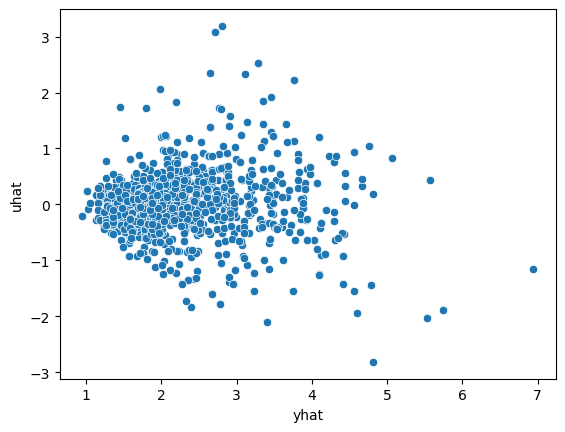

In [3]:
# u hat vs price
sns.scatterplot(x='yhat', y='uhat', data=df);

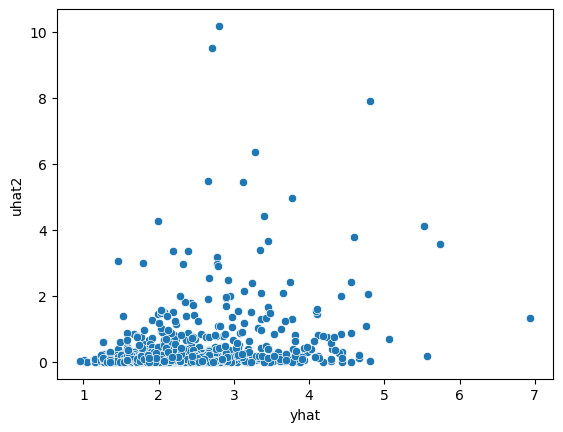

In [4]:
# u_hat^2 vs price
sns.scatterplot(x='yhat', y='uhat2', data=df);

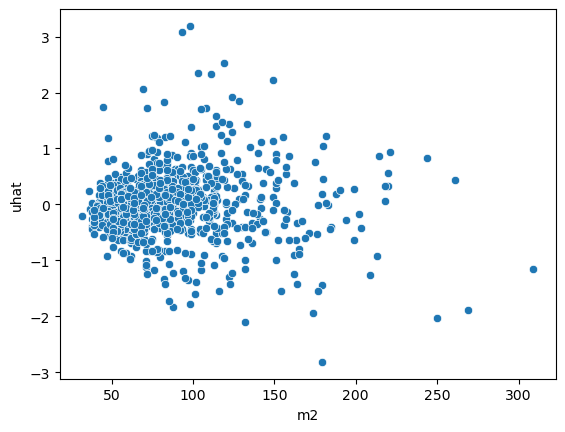

In [5]:
# u_hat vs m2
sns.scatterplot(x='m2', y='uhat', data=df);


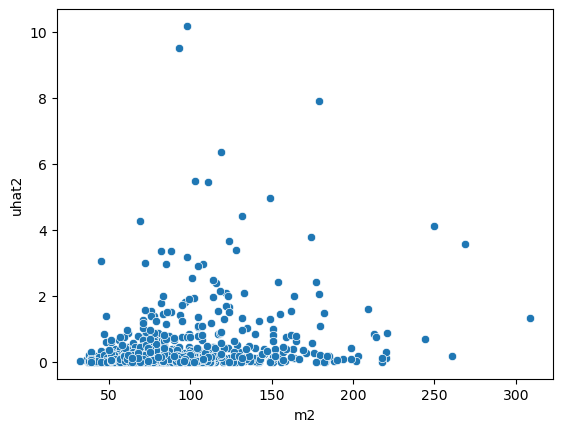

In [6]:
# u_hat^2 vs m2
sns.scatterplot(x='m2', y='uhat2', data=df);


Do the graphs suggest that heteroskedasticity is present? If yes, what type of heteroskedasticity do you find?

**Your answer**

> Graferne viser indikationer af heteroskedasticitet, omend der ikke er et klart mønster i data.


#### Task 3.
Perform the Breusch-Pagan test for heteroskedasticity by regressing $\hat{u}_i^2$ against the right-hand side variables of model (2). Write up the null and alternative hypotheses. Calculate both the $F$ and $LM$ test statistics. Are there signs of heteroskedasticity?


**Your code:**

In [7]:
# Regresser u_hat^2 på højresiden af model (2)
formula = 'uhat2 ~ KbhK + KbhN + KbhV + m2 + m2sq + rooms + toilets'
results = smf.ols(formula, data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  uhat2   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     15.16
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           6.58e-19
Time:                        08:46:17   Log-Likelihood:                -1154.2
No. Observations:                 988   AIC:                             2324.
Df Residuals:                     980   BIC:                             2364.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0469      0.126     -0.372      0.7

In [8]:
# Beregn LM-test
# Vi kan beregne teststatistikken for LM-testen ved at tage antallet af observationer og gange med R^2 fra regressionsoutputtet.
n = len(df) 
R2 = results.rsquared
LM = n * R2 

# Sammenlign med kritisk værdi fra chi2 fordeling
from scipy  import stats 
crit = stats.chi2.ppf(0.95, 7) # 7 restriktioner (de syv forklarende variable er lig nul under nulhypotesen)

# Print resultat
print(f'n: {n}, R2: {R2}, LM: {LM}, crit: {crit}')



n: 988, R2: 0.09773153045407212, LM: 96.55875208862327, crit: 14.067140449340167


In [9]:
# Beregn F-test
# F-teststatistikken og den tilhørende p-værdi for nulhypotesen at hele højresiden er lig nul kan aflæses direkte i regressionsoutputtet, eller vi kan tilgå værdierne med følgende kode:
F = results.fvalue
F_p = results.f_pvalue 

# Print resultat
print(f'F: {F:.4f}, F_p: {F_p:.4f}')

# Tip: Herover bruger jeg .4f for at formatere outputtet til at vise 4 decimaler. Det er en smart funktion når man bruger f-strings.

F: 15.1645, F_p: 0.0000


**Your answer:**

> Nulhypotesen er at fejlleddet i model (2) er homoskedastisk. Det betyder, at de kvadrerede residualer fra OLS regressionen er ukorrelerede med enhver funktion af de forklarende variable. Finder vi at de forklarende variable kan forklare noget af variationen i $\widehat{u}_{i}$, vil vi forkaste nulhypotesen om homoskedasticitet.
> 
> $LM$-testet beregnes her til $LM=988\times 0.0977 = 96.55$. Den kritiske værdi er lig 95th percentilen i $\chi^2$-fordeling med 7 frihedsgrader og beregnes vha. Scipy til 14.07. Ergo afvises nulhypotesen om homoskedasticitet.
> 
> Dette underbygges at $F$-testet for hjælperegressions samlede signifikans, som beregnes til 15.16 med tilhørende p-value = 0.000.




#### Task 4.
Perform a specific Breusch-Pagan test for heteroskedasticity assuming that apartment size is the most likely cause of heteroskedasticity. Perform the test by regressing $\hat{u}_i^2$ against $m2$ and a constant. Write up the null and alternative hypotheses. Calculate a relevant test statistic. What do you conclude?


**Your code:**

In [10]:
# Regresser u_hat^2 på m2 og aflæs t-værdi
results2 = smf.ols('uhat2 ~ m2', data=df).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  uhat2   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     79.38
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           2.42e-18
Time:                        08:46:17   Log-Likelihood:                -1166.8
No. Observations:                 988   AIC:                             2338.
Df Residuals:                     986   BIC:                             2347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1835      0.063     -2.931      0.0

**Your answer:**

> Nulhypotesen er som før. Nu testes blot om de kvadrerede residualer kan forklares af lejlighedens størrelse. Testet udføres som et $t$-test og aflæses af regressionsoutputtet til 8.910, hvorfor nulhypotesen om homoskedasticitet igen afvises. Det ses at koefficienten til $m2$ estimeres til at være positiv, hvorfor $h_i$ her er voksende i $m2$.



#### Task 5.
Suppose that the variance of the error term in model (2) is:

$$
\text{Var}(u_i | X) = \sigma^2 h(X) = \sigma^2 m2_i
$$

where $h(X) = m2_i$. Does this type of heteroskedasticity correspond to your previous finding? Estimate model (2) using the Weighted Least Squares (WLS) estimator.

Make sure you understand both the hint below before you proceed.




_Hint:_ 

You can use the built-in `.wls()` function in statsmodels to estimate the model with the WLS estimator. If you named your dataframe `df` and your squared m2 `m2sq`, you can use the code:

```py
smf.wls('price ~ C(location) + m2 + m2sq + rooms + toilets', weights=1/df.m2, data=df)
```
Note that statsmodels' weight-option defines weights, $w$, that are equivalent to the inverse of Wooldridge's $h$-function. That is, $w=1/h$.



Compare the WLS estimates with the OLS estimates from question 1. Which set of estimates is consistent? Which set of estimates is efficient (meaning having the smallest variance)?


**Your code:**

In [11]:
model = smf.wls('price ~ KbhK + KbhN + KbhV + m2 + m2sq + rooms + toilets', weights=1/df.m2, data=df)
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.657
Model:                            WLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     268.1
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          1.18e-222
Time:                        08:46:17   Log-Likelihood:                -754.00
No. Observations:                 988   AIC:                             1524.
Df Residuals:                     980   BIC:                             1563.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5380      0.106      5.094      0.0

**Your answer:**

> Antagelsen om at variansen på fejlleddet er ligefrem proportional med $m2$ stemmer overens med resultatet i Task 4. WLS resultaterne er præsenteret ovenfor




#### Task 6.
Calculate the WLS estimates manually by dividing all the variables in model (2) by $\sqrt{h(X)} = \sqrt{m2_i}$. 

Make sure you understand both hints below before you proceed.



_Hint 1:_

First of all, we need to manually generate the location dummy variables (we can't use statsmodels' built-in method to generate dummies as previously when we need the transformed versions)

```py
df['KbhK'] = (df.location == 'KBH K')
df['KbhN'] = (df.location == 'KBH N')
df['KbhV'] = (df.location == 'KBH V')
```

Now, to divide all the variables in model (2) by $\sqrt{m2_i}$, you can use this code:

```py
df['w'] = 1/np.sqrt(df.m2) # add the weights as a variable to the dataframe
vars = ['price', 'KbhN', 'KbhO', 'KbhV', 
        'm2', 'm2sq', 'rooms', 'toilets'] # list of variables to be transformed

for var in vars:
    df[f'{var}star'] = df[var] * df.w # Multiply each variable in the list by the weight
```

You can now compute the WLS estimate using OLS with the transformed variables.


_Hint 2_: The intercept in the transformed model will be equal to $1/\sqrt{m2_i}$ and not a constant. For this reason, you have to include the weights $w_i = 1/\sqrt{m2_i}$ as an additional regressor and exclude the constant term. Statsmodels will exclude the automatic constant term if you add `- 1` to your model formula:

```py
formula = 'pricestar ~ KbhNstar + ... + w - 1' # fill in your relevant code ... 
```



Are you able to replicate the results from question 5?



**Your code:**

In [12]:
df['KbhK'] = (df.location == 'KBH K').astype(int)
df['KbhN'] = (df.location == 'KBH N').astype(int)
df['KbhV'] = (df.location == 'KBH V').astype(int)

df['w'] = 1/np.sqrt(df.m2) # add the weights as a variable to the dataframe
for var in ['KbhK', 'KbhN', 'KbhV', 'price', 'm2', 'm2sq', 'rooms', 'toilets']:
    df[f'{var}star'] = df[var] * df.w # Multiply each variable in the list by the weight

formula = 'pricestar ~ w + KbhNstar + KbhKstar + KbhVstar + m2star + m2sqstar + roomsstar + toiletsstar - 1'
results = smf.ols(formula, data=df).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              pricestar   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              2173.
Date:                Fri, 11 Oct 2024   Prob (F-statistic):                        0.00
Time:                        08:46:17   Log-Likelihood:                          1395.5
No. Observations:                 988   AIC:                                     -2775.
Df Residuals:                     980   BIC:                                     -2736.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

**Your answer:**

> Parameterestimater og standardfejl er ens. Vi kan dog ikke bruge $R^2$ og $F$-test for samlet signifikans fra den manuelt vægtede regression. De beregnes på en ikke-standard måde. De er dog beregnet korrekt af Statsmodels i det forrige svar.


#### Task 7.
The OLS estimator is unbiased under MLR.1–MLR.4, but without MLR.5, standard inference is not valid. In the presence of heteroskedasticity, it is however possible to calculate robust standard errors, robust $t$ test statistics, and robust Wald/$F$ test statistics.

Estimate model (2) using OLS with robust standard errors.



_Hint:_ 

To use the robust variance estimator in statsmodels,  use the `.get_robustcov_results()` method of your OLS results object. So wherever you used `results` before, now use `results.get_robustcov_results()`

Alternatively, when estimating your model, you can use `.fit(cov_type='HC1')` instead of just `.fit()`. This is easier in the long run.

If you're wondering what 'HC1' means, it's the name of the specific variant of the robust covariance matrix used. There are multiple alternative versions available. If you are _really_ interested, you can read more here: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.html#statsmodels.regression.linear_model.OLSResults

_Extra hint:_ When using Statsmodels to run OLS regressions using robust standard errors, Statsmodels will per default report z-statistics instead of the usual t-statistics. If you want to prevent this, you can add the argument `use_t=True` to the `.fit()` method. But in this case, the two statistics are identical.

**Your code:**

In [13]:
model3 = smf.ols('price ~ KbhK + KbhN + KbhV + m2 + m2sq + rooms + toilets', data=df)
results3 = model3.fit(cov_type='HC1',  use_t=True)
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     158.0
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          6.13e-156
Time:                        08:46:17   Log-Likelihood:                -850.60
No. Observations:                 988   AIC:                             1717.
Df Residuals:                     980   BIC:                             1756.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6558      0.122      5.391      0.0

Now test the two hypotheses of $\delta_3 = 0$ and $\beta_3 = \beta_4 = 0$ using the robust variance estimator. Explain what the relevant alternative hypotheses are and calculate the relevant test statistics. What do you conclude? 

**Your code:**

In [14]:
results3.f_test(['rooms', 'toilets'])


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=0.4722076946454993, p=0.6237657947466587, df_denom=980, df_num=2>

**Your answer:**

> Hypotesen $H_0:\delta_3=0$ kan testes ved et robust $t$-test. t-statistikken (z-statistikken) kan aflæses direkte i regressionsoutputtet. Her ses det at  $t=-3.936$ med en $p=0.001$, hvorfor nulhypotesen må forkastes. Ergo er der forskel i den gennemsnitlige salgspris for lejligheder i Kbh V relativt til Kbh K.
> 
> Hypotesen $H_0: \beta_3=\beta_4=0$ kan testes med et robust $F$-test. Der beregnes en robust $F$-teststørrelse (svarende til et skaleret Wald test) på 0.4722 med $p=0.62$. Vi kan altså ikke forkaste nulhypotesen at antallet af værelser og toiletter ikke har nogen indflydelse på lejlighedens absolutte pris når vi kontrollerer for lokation og antal kvadratmeter. 


#### Task 8.
Calculate the Breusch-Pagan test for the original model (1), where the dependent variable is $\log(\text{prices})$. Are there signs of heteroskedasticity?


**Your code:**

In [15]:
# Step 1: Estimate the model and save the squared residuals
formula = 'np.log(price) ~ KbhK + KbhN + KbhV + m2 + m2sq + rooms + toilets'
results = smf.ols(formula, data=df).fit()
df['uhat2'] = results.resid ** 2

# Step 2: Estimate the auxiliary regression
formula = 'uhat2 ~ KbhK + KbhN + KbhV + m2 + m2sq + rooms + toilets'
results = smf.ols(formula, data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  uhat2   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.499
Date:                Fri, 11 Oct 2024   Prob (F-statistic):             0.0151
Time:                        08:46:17   Log-Likelihood:                 501.99
No. Observations:                 988   AIC:                            -988.0
Df Residuals:                     980   BIC:                            -948.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0685      0.024      2.907      0.0

In [16]:
N = len(df)
R2 = results.rsquared
LM = N * R2

crit = stats.chi2.ppf(0.95, 7) # 7 restriktioner (de syv forklarende variable er lig nul under nulhypotesen)

print(f'n: {N}, R2: {R2:.4f}, LM: {LM:.4f}, crit: {crit:.4f}')

n: 988, R2: 0.0175, LM: 17.3295, crit: 14.0671


**Your answer:**

For model (1) beregnes Breusch-Pagan testet til $LM=17.33$ og den kritiske værdi beregnes med `scipy` til $c=14.07$. Vi må forkaste nulhypotesen om homoskedasticitet. Dette illusterer, at selvom log-transformation af den afhængige variabel kan mindske problemet med heteroskedastiske fejlled, er det ikke altid nok – det er derfor ofte en god idé at bruge robuste standardfejl.
